In [1]:
import os
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from mp_transformer.config import CONFIG
from mp_transformer.train import setup
from mp_transformer.datasets import ToyDataset
from mp_transformer.utils import save_side_by_side_strip, unroll_from_video, save_generation_video, save_side_by_side_video

In [2]:
current_dir = Path.cwd().parts[-1]
if current_dir == "demo":
    os.chdir("..")
current_dir = Path.cwd().parts[-1]
!pwd
if current_dir != "mp-transformer":
    raise ValueError("Please run this notebook in the project root.")

/data/daniel/git/mp-transformer


In [3]:
CONFIG["hidden_dim"] = 40
CONFIG["latent_dim"] = 48
CONFIG["num_primitives"] = 1
CONFIG["num_attention_heads"] = 1
CONFIG["num_transformer_layers"] = 1
model_vae_single_layer_transformer, _, _ = setup(CONFIG)
model_vae_single_layer_transformer = model_vae_single_layer_transformer.load_from_checkpoint("demo/models/BEST-VAE-single-layer-transformer.ckpt", config=CONFIG)

In [4]:
CONFIG["hidden_dim"] = 40
CONFIG["latent_dim"] = 48
CONFIG["num_primitives"] = 1
CONFIG["num_attention_heads"] = 4
CONFIG["num_transformer_layers"] = 4
model_vae, _, _ = setup(CONFIG)
model_vae = model_vae.load_from_checkpoint("demo/models/BEST-VAE.ckpt", config=CONFIG)

In [5]:
CONFIG["hidden_dim"] = 40
CONFIG["latent_dim"] = 8
CONFIG["num_primitives"] = 6
CONFIG["num_attention_heads"] = 1
CONFIG["num_transformer_layers"] = 1
model_single_layer_transformer, _, _ = setup(CONFIG)
model_single_layer_transformer = model_single_layer_transformer.load_from_checkpoint("demo/models/BEST-single-layer-transformer.ckpt", config=CONFIG)

In [6]:
CONFIG["hidden_dim"] = 40
CONFIG["latent_dim"] = 8
CONFIG["num_primitives"] = 6
CONFIG["num_attention_heads"] = 4
CONFIG["num_transformer_layers"] = 4
model, _, _ = setup(CONFIG)
model = model.load_from_checkpoint("demo/models/BEST-bottleneck.ckpt", config=CONFIG)

In [7]:
models = [model, model_single_layer_transformer, model_vae, model_vae_single_layer_transformer]
model_names = ["model", "model_single_layer_transformer", "model_vae", "model_vae_single_layer_transformer"]

In [8]:
_, _, test_set = setup(CONFIG, test_set=True)
test_dataloader = DataLoader(
    test_set,
    batch_size=CONFIG["batch_size"],
    drop_last=True,
    num_workers=4,
)

In [ ]:
%%capture   # less output

if not os.path.exists("demo/model_comparison.json"):
    trainer = Trainer(gpus=1, logger=False)

    models = [model, model_single_layer_transformer, model_vae, model_vae_single_layer_transformer]
    model_names = ["model", "model_single_layer_transformer", "model_vae", "model_vae_single_layer_transformer"]


    losses = {}
    for m, name in zip(models, model_names):
        res = trainer.test(m, dataloaders=test_dataloader)
        losses[name] = res[0]["avg_test_loss"]
    print(losses)
    with open("demo/model_comparison.json", "w") as f:
        json.dump(losses, f)

UsageError: unrecognized arguments: less output


In [ ]:
%%capture

if not os.path.exists("demo/model_generalization.json"):

    scaling_factors = np.linspace(0.01, 2, 20)

    all_losses = {}

    for m, model_name in zip(models, model_names):
        losses = []
        for scale in scaling_factors:
            # Modify the dataset size based on the current scaling factor
            current_sequence_length = int(CONFIG["sequence_length"] * scale)

            test_dataset = ToyDataset(
                path="data/toy/test-set/",
                return_segments=True,
                sequence_length=current_sequence_length,
                N=CONFIG["N_val"],
            )

            test_dataloader = DataLoader(
                test_dataset,
                batch_size=CONFIG["batch_size"],
                drop_last=True,
                num_workers=4,
            )

            trainer = Trainer(gpus=1, logger=False)
            res = trainer.test(m, dataloaders=test_dataloader)
            losses.append(res[0]["avg_test_loss"])

        all_losses[model_name] = losses

    with open("demo/model_generalization.json", "r") as f:
        all_losses = json.load(f)

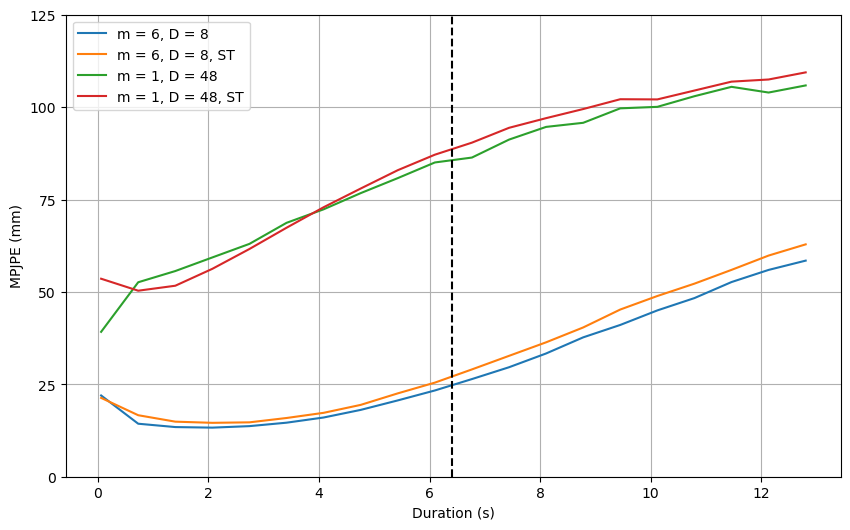

In [ ]:
with open("demo/model_generalization.json", "r") as f:
    all_losses = json.load(f)

# Conversion factor
conversion_factor = 6.4  # 1 scaling factor equals 6.4 seconds

scaling_factors = np.linspace(0.01, 2, 20)
# Calculate durations in seconds
durations = scaling_factors * conversion_factor

model_name_to_label = {
    "model": "m = 6, D = 8",
    "model_single_layer_transformer": "m = 6, D = 8, ST",
    "model_vae": "m = 1, D = 48",
    "model_vae_single_layer_transformer": "m = 1, D = 48, ST"
}

plt.figure(figsize=(10, 6))

for model_name, losses in all_losses.items():
    label = model_name_to_label[model_name]
    plt.plot(durations, losses, label=label)

plt.xlabel("Duration (s)")
plt.ylabel("MPJPE (mm)")
plt.yticks(np.arange(0, 150, 25))
plt.axvline(x=6.4, color='black', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Iterate over the models and print their total number of parameters
for m, model_name in zip(models, model_names):
    num_params = count_parameters(m)
    print(f"{model_name}: {num_params:,} trainable parameters")


model: 1,552,364 trainable parameters
model_single_layer_transformer: 391,124 trainable parameters
model_vae: 2,251,924 trainable parameters
model_vae_single_layer_transformer: 571,204 trainable parameters


In [9]:
item = test_set[4]

In [31]:
save_side_by_side_strip(item, model)

Video saved to tmp/comp_vid.mp4
Video saved to tmp/comp_vid0.mp4
Video saved to tmp/comp_vid1.mp4
Video saved to tmp/comp_vid2.mp4
Video saved to tmp/comp_vid3.mp4
Video saved to tmp/comp_vid4.mp4
Video saved to tmp/comp_vid5.mp4
Moviepy - Building video tmp/comp_strip.mp4.
Moviepy - Writing video tmp/comp_strip.mp4



Moviepy - Done !
Moviepy - video ready tmp/comp_strip.mp4


In [32]:

unroll_from_video(image_path="demo/unrolled_reconstruction_video.png", video_path="tmp/comp_vid.mp4", step=8)

Image saved as unrolled_vertical_from_video.png


In [29]:

item = test_set[9]
# item = test_set[16]
save_side_by_side_strip(item, model)

Video saved to tmp/comp_vid.mp4
Video saved to tmp/comp_vid0.mp4
Video saved to tmp/comp_vid1.mp4
Video saved to tmp/comp_vid2.mp4
Video saved to tmp/comp_vid3.mp4
Video saved to tmp/comp_vid4.mp4
Video saved to tmp/comp_vid5.mp4
Moviepy - Building video tmp/comp_strip.mp4.
Moviepy - Writing video tmp/comp_strip.mp4



Moviepy - Done !
Moviepy - video ready tmp/comp_strip.mp4


In [30]:
unroll_from_video(image_path="demo/unrolled_primitive_video.png", video_path="tmp/comp_strip.mp4")

Image saved as unrolled_vertical_from_video.png


In [10]:
save_generation_video(model, path="demo/generation_video.mp4")

Video saved to demo/generation_video.mp4


In [11]:
unroll_from_video(image_path="demo/unrolled_generation_video.png", video_path="demo/generation.mp4", step=8)

Image saved as unrolled_vertical_from_video.png


In [13]:
# fill in video
save_side_by_side_video(item, model, from_idx=1, to_idx=4)

poses range: [2.3245827378559625e-06, 0.9999611377716064]
mus range: [-1.2102930545806885, 1.0922013521194458]
average mu: 0.006520887371152639
logvars range: [-8.466848373413086, -5.703087329864502]
median logvar: -7.527785301208496
gt_latents range: [-2.5240426063537598, 2.284752368927002]
average gt_latents: 0.11141959577798843
random_latents range: [-1.1738234758377075, 1.0749876499176025]
average random_latents: 0.0015033433446660638
Video saved to tmp/comp_vid.mp4


In [15]:
# Completion 1
save_side_by_side_video(item, model, from_idx=3)

poses range: [2.3245827378559625e-06, 0.9999611377716064]
mus range: [-0.998945951461792, 1.1654844284057617]
average mu: 0.059327974915504456
logvars range: [-8.52099895477295, -5.509519577026367]
median logvar: -7.215140342712402
gt_latents range: [-2.3949685096740723, 2.098458766937256]
average gt_latents: 0.11100565642118454
random_latents range: [-1.0680592060089111, 1.1592532396316528]
average random_latents: 0.05421747639775276
Video saved to tmp/comp_vid.mp4


In [16]:
# Completion 2
save_side_by_side_video(item, model, from_idx=2)

poses range: [2.3245827378559625e-06, 0.9999611377716064]
mus range: [-1.2953771352767944, 1.4403305053710938]
average mu: -0.10350888967514038
logvars range: [-8.498364448547363, -5.490082263946533]
median logvar: -7.446098327636719
gt_latents range: [-2.550565719604492, 2.2558751106262207]
average gt_latents: 0.1182718500494957
random_latents range: [-1.251528024673462, 1.4447168111801147]
average random_latents: -0.09419620782136917
Video saved to tmp/comp_vid.mp4
